In [1]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback

from torch.utils.data import DataLoader

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
os.environ["WANDB_DISABLED"] = "true"

In [69]:
!wandb server stop

Usage: wandb [OPTIONS] COMMAND [ARGS]...
Try 'wandb --help' for help.

Error: No such command 'server'.


In [20]:
data_dir = '/Users/akhanko/Work/Projector Test Task/data'
train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')

train_df = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [3]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


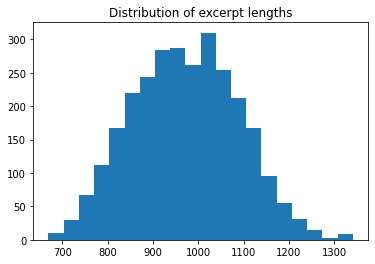

In [4]:
train_df['excerpt_len'] = train_df.excerpt.apply(len)

plt.hist(train_df['excerpt_len'], bins=20)
plt.title('Distribution of excerpt lengths')
plt.show()

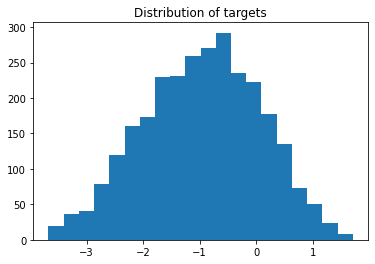

In [5]:
plt.hist(train_df['target'], bins=20)
plt.title('Distribution of targets')
plt.show()

In [6]:
test_df

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [ ]:
plt.hist(train_df['target'], bins=20)
plt.title('Distribution of targets in train set')
plt.show()

In [7]:
train, valid = train_test_split(train_df, train_size=0.7, random_state=0)

In [21]:
train.shape, valid.shape, test.shape

((1983, 8), (851, 8), (7, 4))

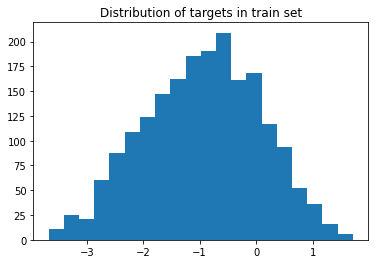

In [9]:
plt.hist(train['target'], bins=20)
plt.title('Distribution of targets in train set')
plt.show()

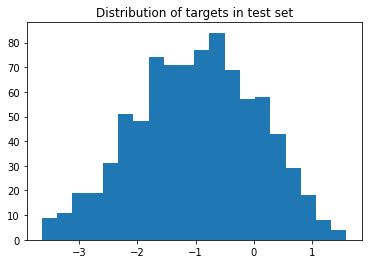

In [14]:
plt.hist(valid['target'], bins=20)
plt.title('Distribution of targets in test set')
plt.show()

In [39]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode(text, max_len=512):
    return tokenizer(text, padding='max_length', max_length=max_len)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/akhanko/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  

In [40]:
train['encoded'] = train.excerpt.apply(encode)
valid['encoded'] = valid.excerpt.apply(encode)
test['encoded'] = test.excerpt.apply(encode)

In [41]:
train['encoded']

937     [input_ids, attention_mask]
575     [input_ids, attention_mask]
2088    [input_ids, attention_mask]
2641    [input_ids, attention_mask]
587     [input_ids, attention_mask]
                   ...             
763     [input_ids, attention_mask]
835     [input_ids, attention_mask]
1653    [input_ids, attention_mask]
2607    [input_ids, attention_mask]
2732    [input_ids, attention_mask]
Name: encoded, Length: 1983, dtype: object

In [42]:
class ReadabilityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = self.encodings[idx]
        item["labels"] = float(torch.tensor([self.labels[idx]]))
        return item

    def __len__(self):
        return len(self.labels)

In [43]:
train_dataset = ReadabilityDataset(train.encoded.values, train.target.values)
valid_dataset = ReadabilityDataset(valid.encoded.values, valid.target.values)

In [44]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [45]:
train.encoded.values[0]

{'input_ids': [0, 13624, 6, 9436, 6966, 50, 15754, 13215, 11, 26140, 126, 11, 5, 514, 11, 110, 5797, 6, 11, 10580, 314, 2828, 15, 5, 3231, 6, 50, 6, 114, 10, 621, 34, 10, 1925, 7910, 6, 190, 11, 1050, 1925, 4, 3323, 16364, 2386, 9436, 7, 517, 198, 7, 465, 689, 6, 50, 517, 409, 31, 383, 51, 109, 45, 101, 6, 215, 25, 4520, 20843, 6, 50, 4590, 31, 5, 1050, 809, 14, 236, 7, 3529, 9436, 4, 125, 6, 144, 9436, 74, 1195, 2662, 202, 87, 6966, 198, 4, 28060, 202, 1239, 540, 1007, 6, 8, 9436, 14, 2662, 11, 5, 235, 1514, 64, 2067, 13, 689, 7, 283, 7, 106, 4, 28060, 202, 16, 5, 78, 1149, 11, 442, 10, 25738, 10709, 21928, 4, 20, 78, 39797, 4031, 14, 6476, 202, 429, 28, 1770, 30, 643, 6, 50, 24, 429, 33942, 8, 146, 171, 55, 9436, 14, 32, 11288, 9, 1495, 4, 520, 55, 8, 55, 9436, 120, 561, 6, 51, 386, 7, 146, 25247, 15883, 373, 8935, 12326, 45357, 11424, 30998, 15883, 14, 51, 1719, 1235, 19, 4, 152, 25247, 435, 9, 9436, 16, 373, 10, 10709, 21928, 4, 20, 9436, 11, 10, 10709, 21928, 697, 16534, 4441, 304

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/akhanko/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": tr

In [47]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

In [48]:
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 1,     
    per_device_train_batch_size = 32,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [49]:
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = valid_dataset,          
    compute_metrics = compute_metrics,     
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 1983
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 62
